# **1. Initialization - Import / Install libraries**



In [1]:
# This is a magic function to generate the graph within the notebook 
%matplotlib inline

# Install library 
!pip install nltk
!pip install pymysql

In [2]:
# Here is a list of libraries we need to conduct the analysis:
import pandas as pd                                           # Loading files into pandas dataframe
import numpy as np                                            # To use numpy aggregation functions
from tqdm.auto import tqdm                                    # track loop time
import warnings                                               # Suppress all warnings
warnings.filterwarnings('ignore')
import pickle
import pymysql
import re
import json
import model_shared_utilities as msu                          # helper functions 
import topic_model_utilities as tm                            # helper functions
# --------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                               # Generate visualization 
import matplotlib.cm as cm
import altair as alt                                          
import seaborn as sns
# --------------------------------------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler              # Transforming dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.tokenize import sent_tokenize
# --------------------------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split          # Model Training
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score 
from sklearn.model_selection import StratifiedKFold        
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
# --------------------------------------------------------------------------------------------------
from sklearn.metrics.pairwise import cosine_similarity        # Calculate the similarity between word vectors
# --------------------------------------------------------------------------------------------------
import nltk                                                   # Downloading necessary packagings from nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk

True

In [3]:
# use this to set random_state to reproduce the same result
RANDOM_SEED = 14


# **2. Load / Transform Datasets**

In [4]:
# read the secret keys from json file 
# Note the config file need to be filled with your own credentials before running this notebook 
# or ask the owners of this repository for the filled config file
with open('config.json', 'r') as f:
    secret = json.load(f)

In [5]:
# connect to the database
connection = pymysql.connect(host=secret['host'],
                              user=secret['user'],
                              password=secret['password'],
                              database=secret['database'],
                              port=secret['port'],
                              charset=secret['charset'],
                              cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

cursor.execute("SELECT * FROM jd;")
table = cursor.fetchall()

cursor.execute("SELECT * FROM companies;")
table2 = cursor.fetchall()

connection.close()

In [6]:
# Now let's put the tables into pandas dataframe 
job_df = pd.DataFrame(table)
job_df = job_df.dropna(subset=['job_description'])
print("Job dataset has", job_df.shape[0], "rows of data")

company_df = pd.DataFrame(table2)
print("Company dataset has", company_df.shape[0], "rows of data")

Job dataset has 18087 rows of data
Company dataset has 1024219 rows of data


In [7]:
# let's load the list of domains we have defined/condensed from the industry column from company_df  
filename = 'domain_list.xlsx'
domain_df = pd.read_excel(filename)

# extracting the domains for the job postings
df = msu.get_labels(domain_df, company_df, job_df, dropna=False)

In [8]:
labeled_df = df[~df.job_domain.isna()]
unlabeled_df = df[df.job_domain.isna()]
print("Labeled dataset has", labeled_df.shape[0], "rows of data")
print("Unlabeled dataset has", unlabeled_df.shape[0], "rows of data")

Labeled dataset has 10399 rows of data
Unlabeled dataset has 7688 rows of data


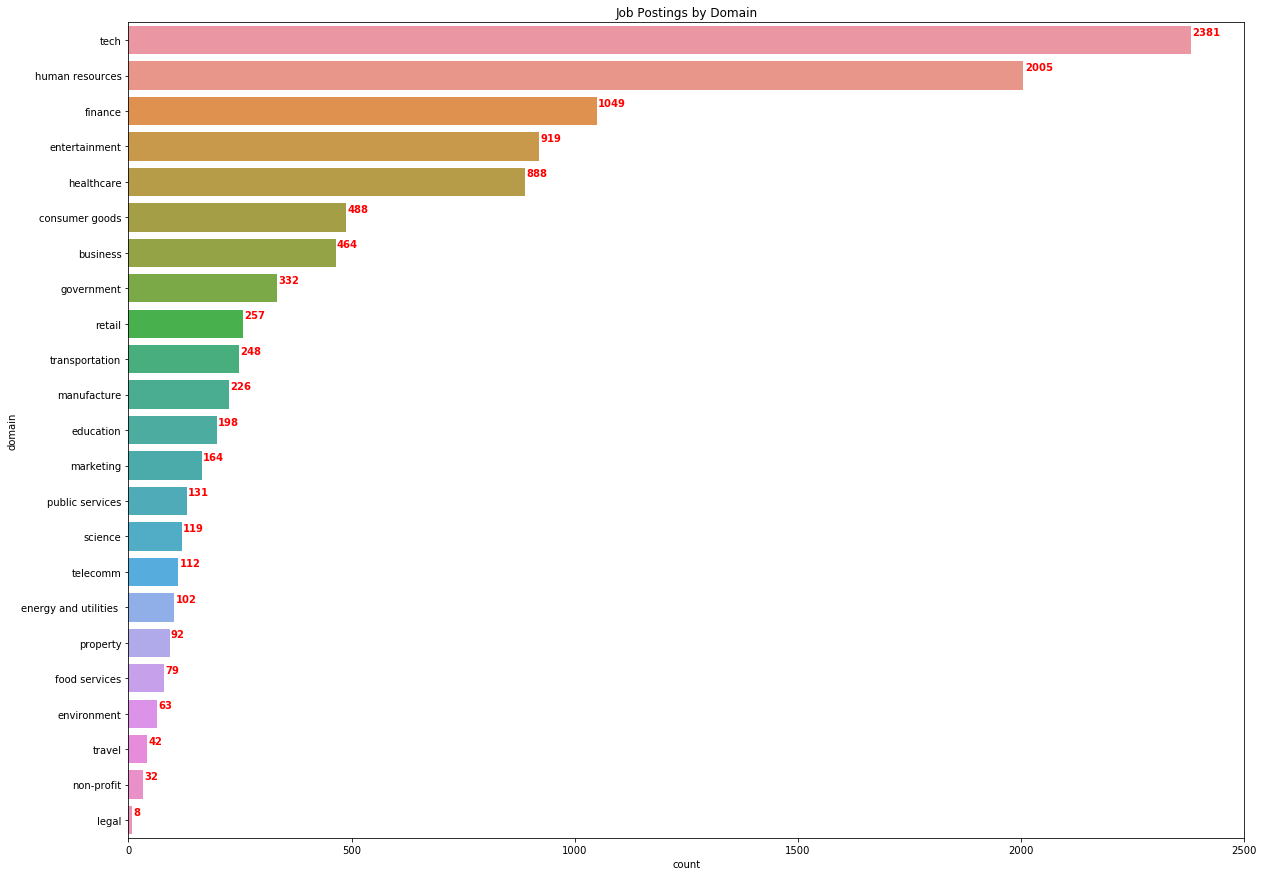

In [9]:
# let's look at the number of job postings for each domain (from the labeled dataset)
agg_df = labeled_df.job_domain.value_counts()
plt.figure(figsize=(20,15))
sns.barplot(agg_df, agg_df.index)

# add annotation to each bar to show the counts
for i, v in enumerate(agg_df):
    plt.text(v + 3, i -.15, str(v), color='red', fontweight='bold')

plt.title('Job Postings by Domain')
plt.ylabel('domain')
plt.xlabel('count')
plt.show()

# Note: we have an imbalanced dataset!

In [10]:
# creating instance of labelencoder
# this is to transform the categorical label(domain) into integers
labelencoder = LabelEncoder()

labeled_df['domain_label'] = labelencoder.fit_transform(labeled_df['job_domain'])

In [11]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000,              # only top n by freq
                                   lowercase=True,                  # keep caps
                                   token_pattern=r"[A-Za-z]{4,15}", # words with 4 to 15 characters
                                   ngram_range=(1,2),               # include 2-word phrases
                                   min_df=25,                       # note: absolute count of doc
                                   max_df=0.75,                     # note: % of docs
                                   stop_words='english')            # default English stopword
                                   
# Count Vectorizer
tf_vectorizer = CountVectorizer(max_features=10000,              # only top n by freq
                                lowercase=True,                  # keep caps
                                token_pattern=r"[A-Za-z]{4,15}", # words with 4 to 15 characters
                                ngram_range=(1,2),               # include 2-word phrases
                                min_df=25,                       # note: absolute count of doc
                                max_df=0.75,                     # note: % of docs
                                stop_words='english')            # default English stopword

In [12]:
# transforming the data
tfidf_docs = tfidf_vectorizer.fit_transform(labeled_df["job_description"])  
print(tfidf_docs.shape)
tfidf_terms = tfidf_vectorizer.get_feature_names()

tf_docs = tf_vectorizer.fit_transform(labeled_df["job_description"])  
print(tf_docs.shape)
tf_terms = tf_vectorizer.get_feature_names()

(10399, 10000)
(10399, 10000)


# **3. Model Selection** (with raw job description) 

In this section, we will be evaluating different models performances based on accuracy and f-1 scores with both the bag of words approach and TF-IDF. Then we will take models with the highest performance for parameters tuning in the next section Model Training.

In [13]:
# This is to establish a baseline for the models we want to evaluate
dummy_clf = DummyClassifier(strategy="most_frequent")
X = tfidf_docs
y = labeled_df.domain_label
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, stratify=y)

dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print("Accuracy score of dummy classifier:", accuracy_score(y_test, y_pred))
print("F-1 score of dummy classifier:", f1_score(y_test, y_pred, average='weighted'))

Accuracy score of dummy classifier: 0.22884615384615384
F-1 score of dummy classifier: 0.0852353436860479


In [14]:
# initialize models 
model_mnb = MultinomialNB()
model_lr = LogisticRegression(random_state=RANDOM_SEED)
model_knn = KNeighborsClassifier()
model_rf = RandomForestClassifier(random_state=RANDOM_SEED)

# let's put them in a list
models = [model_mnb, model_lr, model_knn, model_rf]
models_name = ['Multinomial Naive Bayes', 'Logistic Regression', 'K-Nearest Neighbors', 'Random Forest']

In [15]:
# Let's look at the labeled data we current have 
labeled_df.sample(3)

,company_name,industry,id,crawl_timestamp,url,job_title,category,city,state,country,...,html_job_description,company_description,location,education,skill,cleaned_jd,domain_minik,domain_lr,job_domain,domain_label
5406,lumber liquidators,retail,1678,2019-02-18,https://www.indeed.com/viewjob?jk=804b9ba30963...,"Data Scientist - Richmond, Virginia (VA)",Manufacturing/Mechanical,Toano,VA,UNITED STATES,...,,None,None,bachelor;master,"acc, data analytics, excel, python, tableau, v...","data scientist - richmond, virginia (va); read...",marketing,retail,retail,17
4076,carilion clinic,hospital & health care,10331,2019-09-15,https://www.theladders.com/job/healthcare-stat...,Healthcare Statistician - Data Scientist in Ro...,Healthcare Statistician - Data Scientist,Roanoke,VA,UNITED STATES,...,"<div class=""job-description job-description-te...",None,None,bachelor,"information systems, python, sas, sql, statist...",healthcare statistician - data scientist in ro...,business,healthcare,healthcare,9
5284,the judge group,information technology and services,10025,2019-09-10,https://job-openings.monster.com/data-scientis...,Data Scientist (627979),computer jobs,Yonkers,NY,UNITED STATES,...,<span id='TrackingJobBody' name='TrackingJobBo...,None,None,bachelor,"apache, aws, bamboo, bash, big data, data mode...",data scientist (627979); our client is current...,tech,tech,tech,19


In [16]:
# now let's train the models using tfidf and tf
# and evaluate the models by comparing accuracy and f-1 score
acc = []
f1 = []
for X in [tfidf_docs, tf_docs]:
    y = labeled_df.domain_label
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, stratify=y)

    a = []
    f = []
    for m in tqdm(models): 
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        a.append(accuracy_score(y_test, y_pred))
        f.append(f1_score(y_test, y_pred, average='weighted'))

    acc.append(a)
    f1.append(f) 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

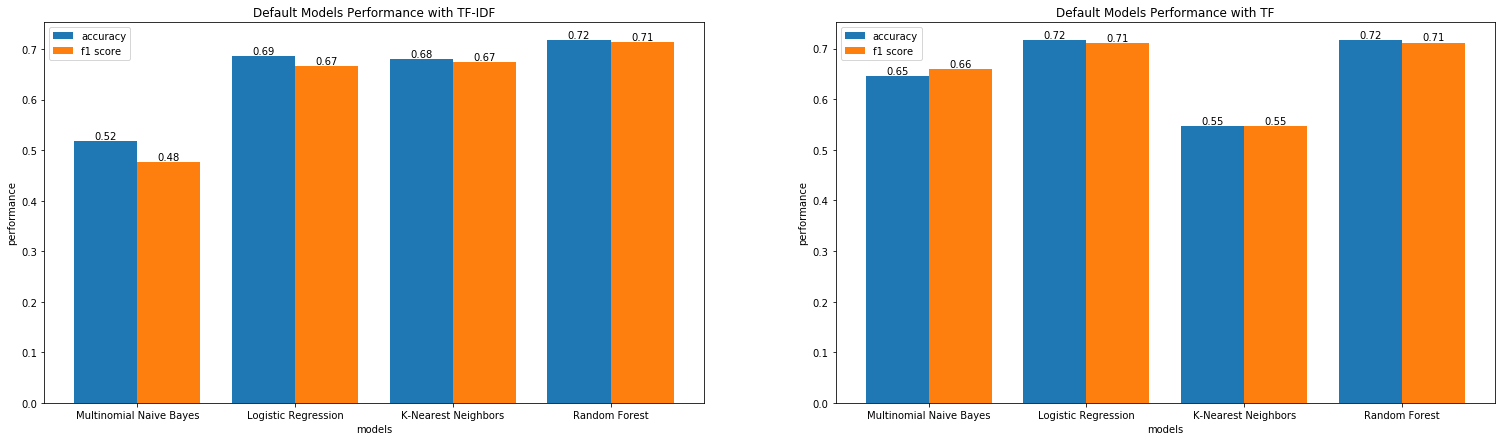

In [17]:
# let's plot the result and compare the performance based on model accuracy and f1 score
fig, ax = plt.subplots(1,2, figsize=(26,7))
for i in range(2): 
  X_axis = np.arange(len(models_name))
    
  bar1 = ax[i].bar(X_axis - 0.2, acc[i], 0.4, label = 'accuracy')
  bar2 = ax[i].bar(X_axis + 0.2, f1[i], 0.4, label = 'f1 score')

  ax[i].set_xticks(X_axis)
  ax[i].set_xticklabels(models_name)
  ax[i].set_xlabel("models")
  ax[i].set_ylabel("performance")
  ax[i].legend()

  # add values on top of each bar
  for bar in [bar1, bar2]:
    for rect in bar:
      h = rect.get_height()
      ax[i].text(rect.get_x()+rect.get_width()/2., h, f'{h:.2f}',
                    ha='center', va='bottom')
          
ax[0].set_title("Default Models Performance with {}".format('TF-IDF'))  
ax[1].set_title("Default Models Performance with {}".format('TF'))  
plt.show()

In [18]:
# from what we see above, Random Forest performs the best with TF-IDF and Logistic Regression performs the best with TF 
# so in the upcoming section, we will continue to train RF and LR models  

# **4. Model Training** 

In this section, we will be using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to tune parameters on [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). We will also be training the models with both the raw job descriptions and the cleaned job descriptions. The model with the best performance will be used to predict the domain for the unlabeled dataset.  

## 4.A. Train with Raw Job Descriptions

In [19]:
# transforming the data
tfidf_docs = tfidf_vectorizer.fit_transform(labeled_df["job_description"])  
print(tfidf_docs.shape)
tfidf_terms = tfidf_vectorizer.get_feature_names()

tf_docs = tf_vectorizer.fit_transform(labeled_df["job_description"])  
print(tf_docs.shape)
tf_terms = tf_vectorizer.get_feature_names()

# split into train and test set
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tf_docs, labeled_df.domain_label, 
                                                                stratify=y, random_state=RANDOM_SEED)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_docs, labeled_df.domain_label, 
                                                                            stratify=y, random_state=RANDOM_SEED)


(10399, 10000)
(10399, 10000)


### 4.A.1. Logistic Regression

In [20]:
# # set up the model and variables for training
# model = LogisticRegression()

# # define grid search for tuning the parameters
# grid_params = {
#                 'solver':['newton-cg', 'sag', 'lbfgs'],
#                 'C':[100, 10, 1.0, 0.1]
#                }
# cv = StratifiedKFold(random_state=RANDOM_SEED)
# grid_search = GridSearchCV(model, grid_params, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=10)
# grid_result = grid_search.fit(X_train_tf, y_train_tf)

# y_pred = grid_search.predict(X_test_tf)
# f1 = f1_score(y_test_tf, y_pred, average='weighted')

# # summarize results
# print("Best parameters: {}".format(grid_result.best_params_))
# print("Best cross-validation score: {:.4f}".format(grid_result.best_score_))
# print("F1 score with best parameters on the test set: {:.4f}".format(f1))

#-------------------------------------------------------------------------------
# The result is recorded below so we don't need to rerun this cell everytime
# Best parameters: {'C': 0.1, 'solver': 'newton-cg'}
# Best cross-validation score: 0.7087
# F1 score with best parameters on the test set: 0.7195

In [21]:
# using the best parameter found using grid search above and retrain a Logistic Regression model (reason for the retrain is because it takes a long time to run the gridsearch so don't want to rerun it everytime) 
model = LogisticRegression(C=0.1, solver='newton-cg', random_state=RANDOM_SEED)
model.fit(X_train_tf, y_train_tf)
y_pred = model.predict(X_test_tf)
f1 = f1_score(y_test_tf, y_pred, average='weighted')

print("F1 score with best parameters on the test set: {:.4f}".format(f1))

F1 score with best parameters on the test set: 0.7195


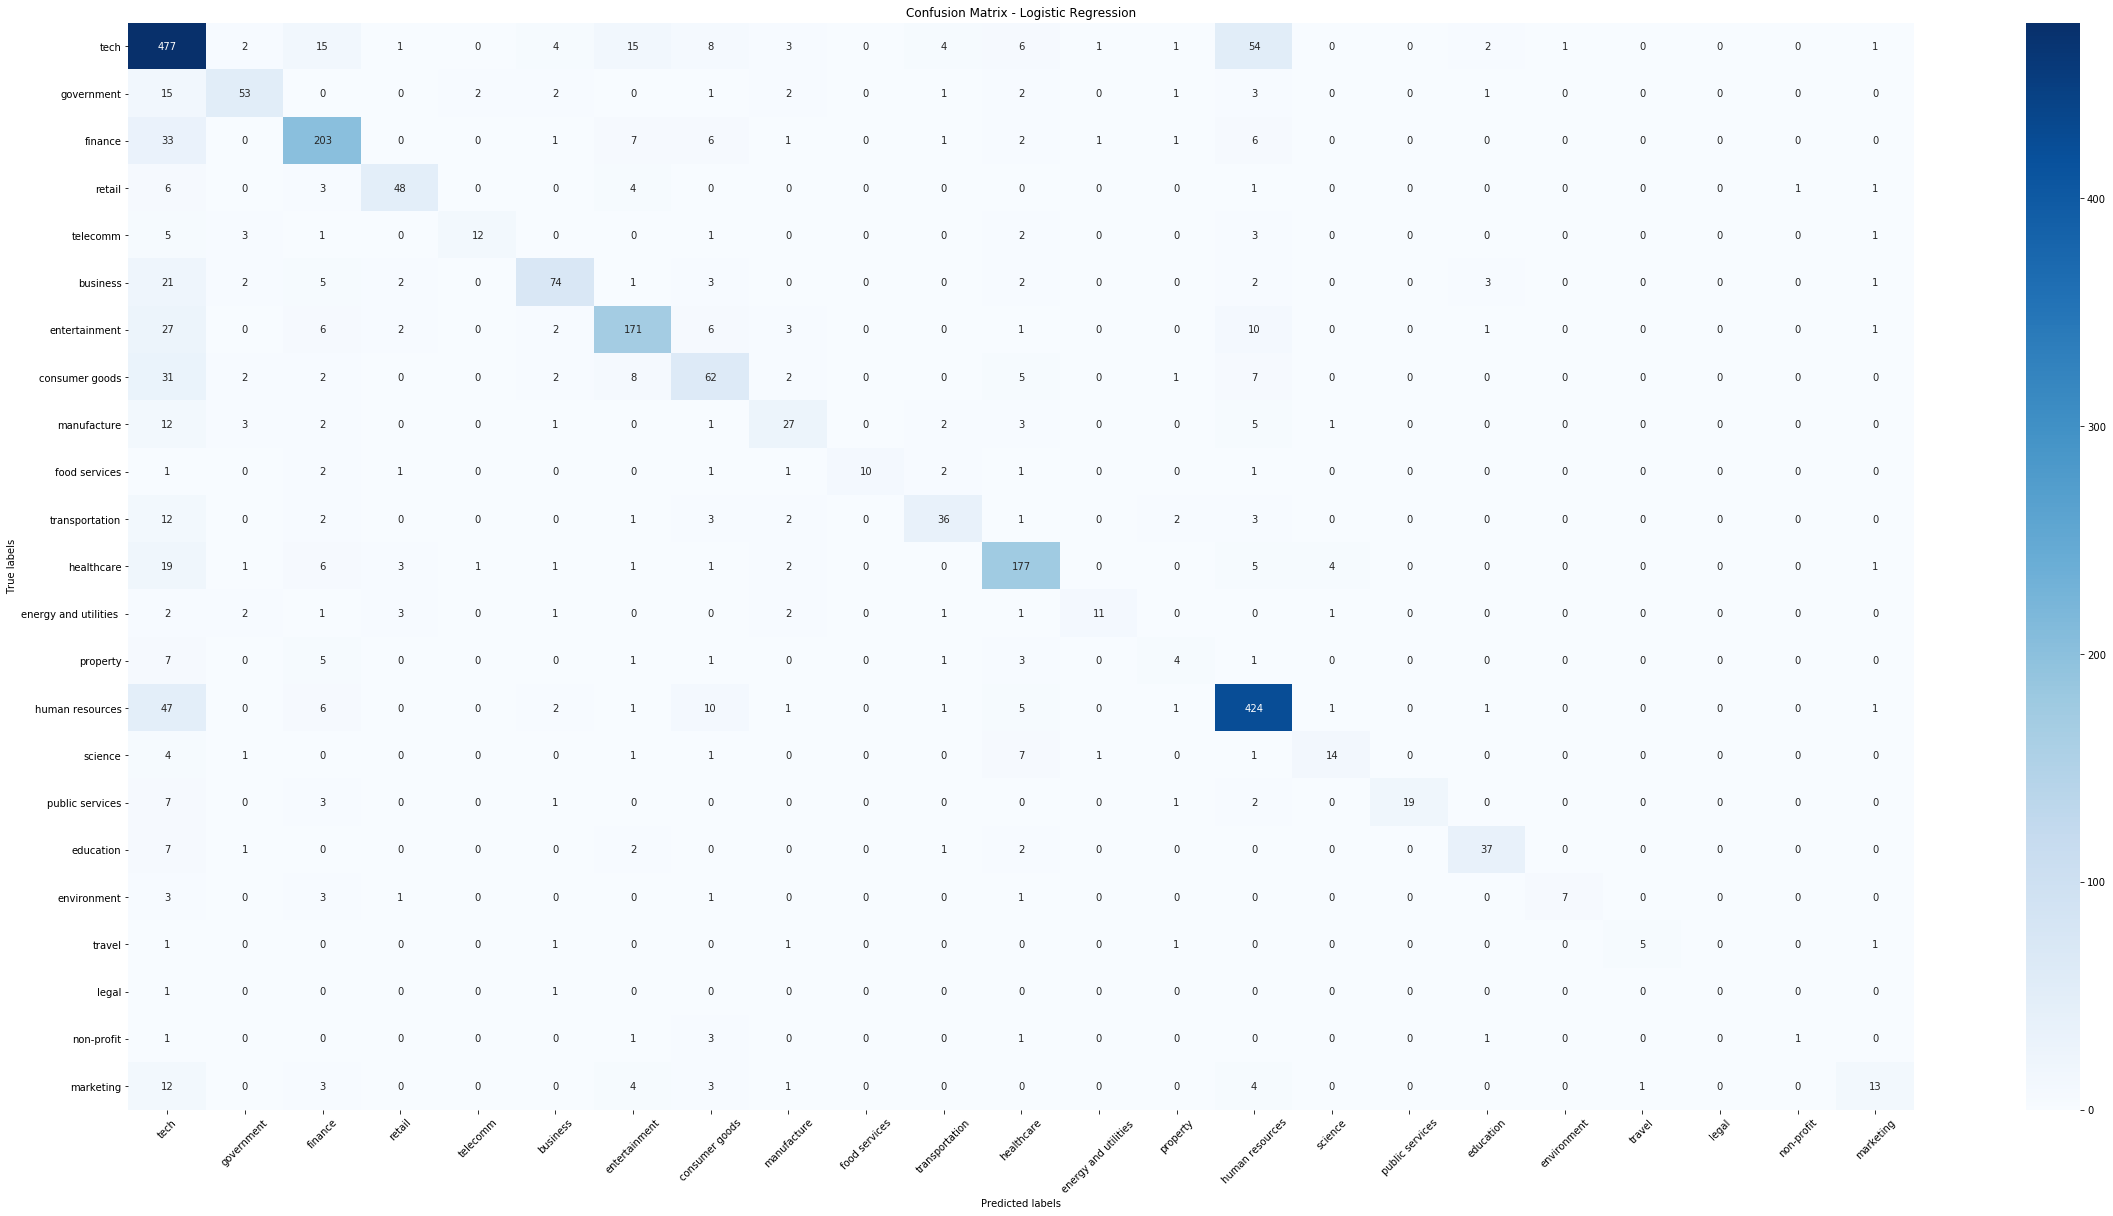

In [22]:
# this is use to help label the confusion matrix axis 
df_labels = labeled_df[['job_domain', 'domain_label']].drop_duplicates()

# now evaluate the model using confusion matrix 
cm = confusion_matrix(y_test_tf, y_pred, labels=df_labels.domain_label)

# let's plot the confusion matrix as heatmap and see how the model perform for each domain
fig, ax = plt.subplots(figsize=(40,20))

sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Logistic Regression'); 
ax.xaxis.set_ticklabels(df_labels.job_domain, rotation=45); 
ax.yaxis.set_ticklabels(df_labels.job_domain, rotation=0);

In [23]:
# now that we are happy with our model, we can train the model with all the labeled data and predict labels for the unlabeled dataset
model = LogisticRegression(C=0.1, solver='newton-cg', random_state=RANDOM_SEED)
model.fit(tf_docs, labeled_df.domain_label)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=14, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
# transform the job description of the unlabeled data and predict labels using the trained model 
unlabeled_X = tf_vectorizer.transform(unlabeled_df["job_description"]) 
unlabeled_df['pred_label'] = model.predict(unlabeled_X)

# now drop the job_domain column and do a merge with the df_labels to get the actual domain for each label
# note: pred_label is in integers so we need to do this to transform it back to domain 
unlabeled_df = unlabeled_df.drop(columns=['job_domain'])
pred_df = unlabeled_df.merge(df_labels, how='left', left_on='pred_label', right_on='domain_label')
pred_df.sample(3)

,company_name,industry,id,crawl_timestamp,url,job_title,category,city,state,country,...,company_description,location,education,skill,cleaned_jd,domain_minik,domain_lr,pred_label,job_domain,domain_label
4256,novo nordisk u.s.,NaN,10368,2019-09-15,https://www.theladders.com/job/data-scientist-...,"Data Scientist II in Seattle, WA",Data Scientist II,Seattle,WA,UNITED STATES,...,None,None,bachelor;master;phd,"active learning, artificial intelligence, base...","data scientist ii in seattle, wa; about the de...",tech,healthcare,9,healthcare,9
5885,syrinx,NaN,116605,2021-07-16,https://www.glassdoor.com/job-listing/data-sci...,Data Scientist,None,Waltham,MA,,...,None,"Waltham, Massachusetts",,"aws, azure, excel, hadoop, machine learning",data scientist; skills and knowledge you shoul...,tech,tech,19,tech,19
164,colgate-palmolive,NaN,552,2021-07-08,https://www.glassdoor.com/job-listing/data-eng...,Data Engineer,,Piscataway,NJ,UNITED STATES,...,None,None,bachelor,"ajax, aws, big data, data structures, hadoop, ...",data engineer; no relocation assistance offere...,tech,consumer goods,1,consumer goods,1


In [25]:
# # record the result into the database
# connection = pymysql.connect(host=secret['host'],
#                               user=secret['user'],
#                               password=secret['password'],
#                               database=secret['database'],
#                               port=secret['port'],
#                               charset=secret['charset'],
#                               cursorclass=pymysql.cursors.DictCursor)

# cursor = connection.cursor()

# for i in tqdm(range(pred_df.shape[0])):
#     id = pred_df.iloc[i]['id']
#     domain = pred_df.iloc[i]['job_domain']
#     cursor.execute(f"""UPDATE jd SET domain_lr='{domain}' WHERE id={id};""")
#     if i%1000 == 0: 
#       connection.commit()
# connection.commit()

# connection.close()

### 4.A.2. Random Forest Classifier

In [26]:
# # set up the model and variables for training
# model = RandomForestClassifier(random_state=RANDOM_SEED)

# # define grid search
# grid_params = {
#                 'min_samples_leaf':[1,5,15],
#                 'n_estimators': [500,700,950,1000],
#                 'max_depth': [100,150,200,250]
#                 }
# cv = StratifiedKFold(random_state=RANDOM_SEED)
# grid_search = GridSearchCV(model, grid_params, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=20)
# grid_result = grid_search.fit(X_train_tfidf, y_train_tfidf)

# y_pred = grid_search.predict(X_test_tfidf)
# f1 = f1_score(y_test_tfidf, y_pred, average='weighted')

# # summarize results
# print("Best parameters: {}".format(grid_result.best_params_))
# print("Best cross-validation score: {:.4f}".format(grid_result.best_score_))
# print("F1 score with best parameters on the test set: {:.4f}".format(f1))

#-------------------------------------------------------------------------------
# The result is recorded below so we don't need to rerun this cell everytime
# Best parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'n_estimators': 1000}
# Best cross-validation score: 0.6868
# F1 score with best parameters on the test set: 0.7109

In [27]:
# using the best parameter found using grid search above and retrain a RF model (reason for the retrain is because it takes a long time to run the gridsearch so don't want to rerun it everytime) 
model = RandomForestClassifier(max_depth=100, min_samples_leaf=1, n_estimators=1000, random_state=RANDOM_SEED)
model.fit(X_train_tfidf, y_train_tfidf)
y_pred = model.predict(X_test_tfidf)
f1 = f1_score(y_test_tfidf, y_pred, average='weighted')

print("F1 score with best parameters on the test set: {:.4f}".format(f1))

F1 score with best parameters on the test set: 0.7109


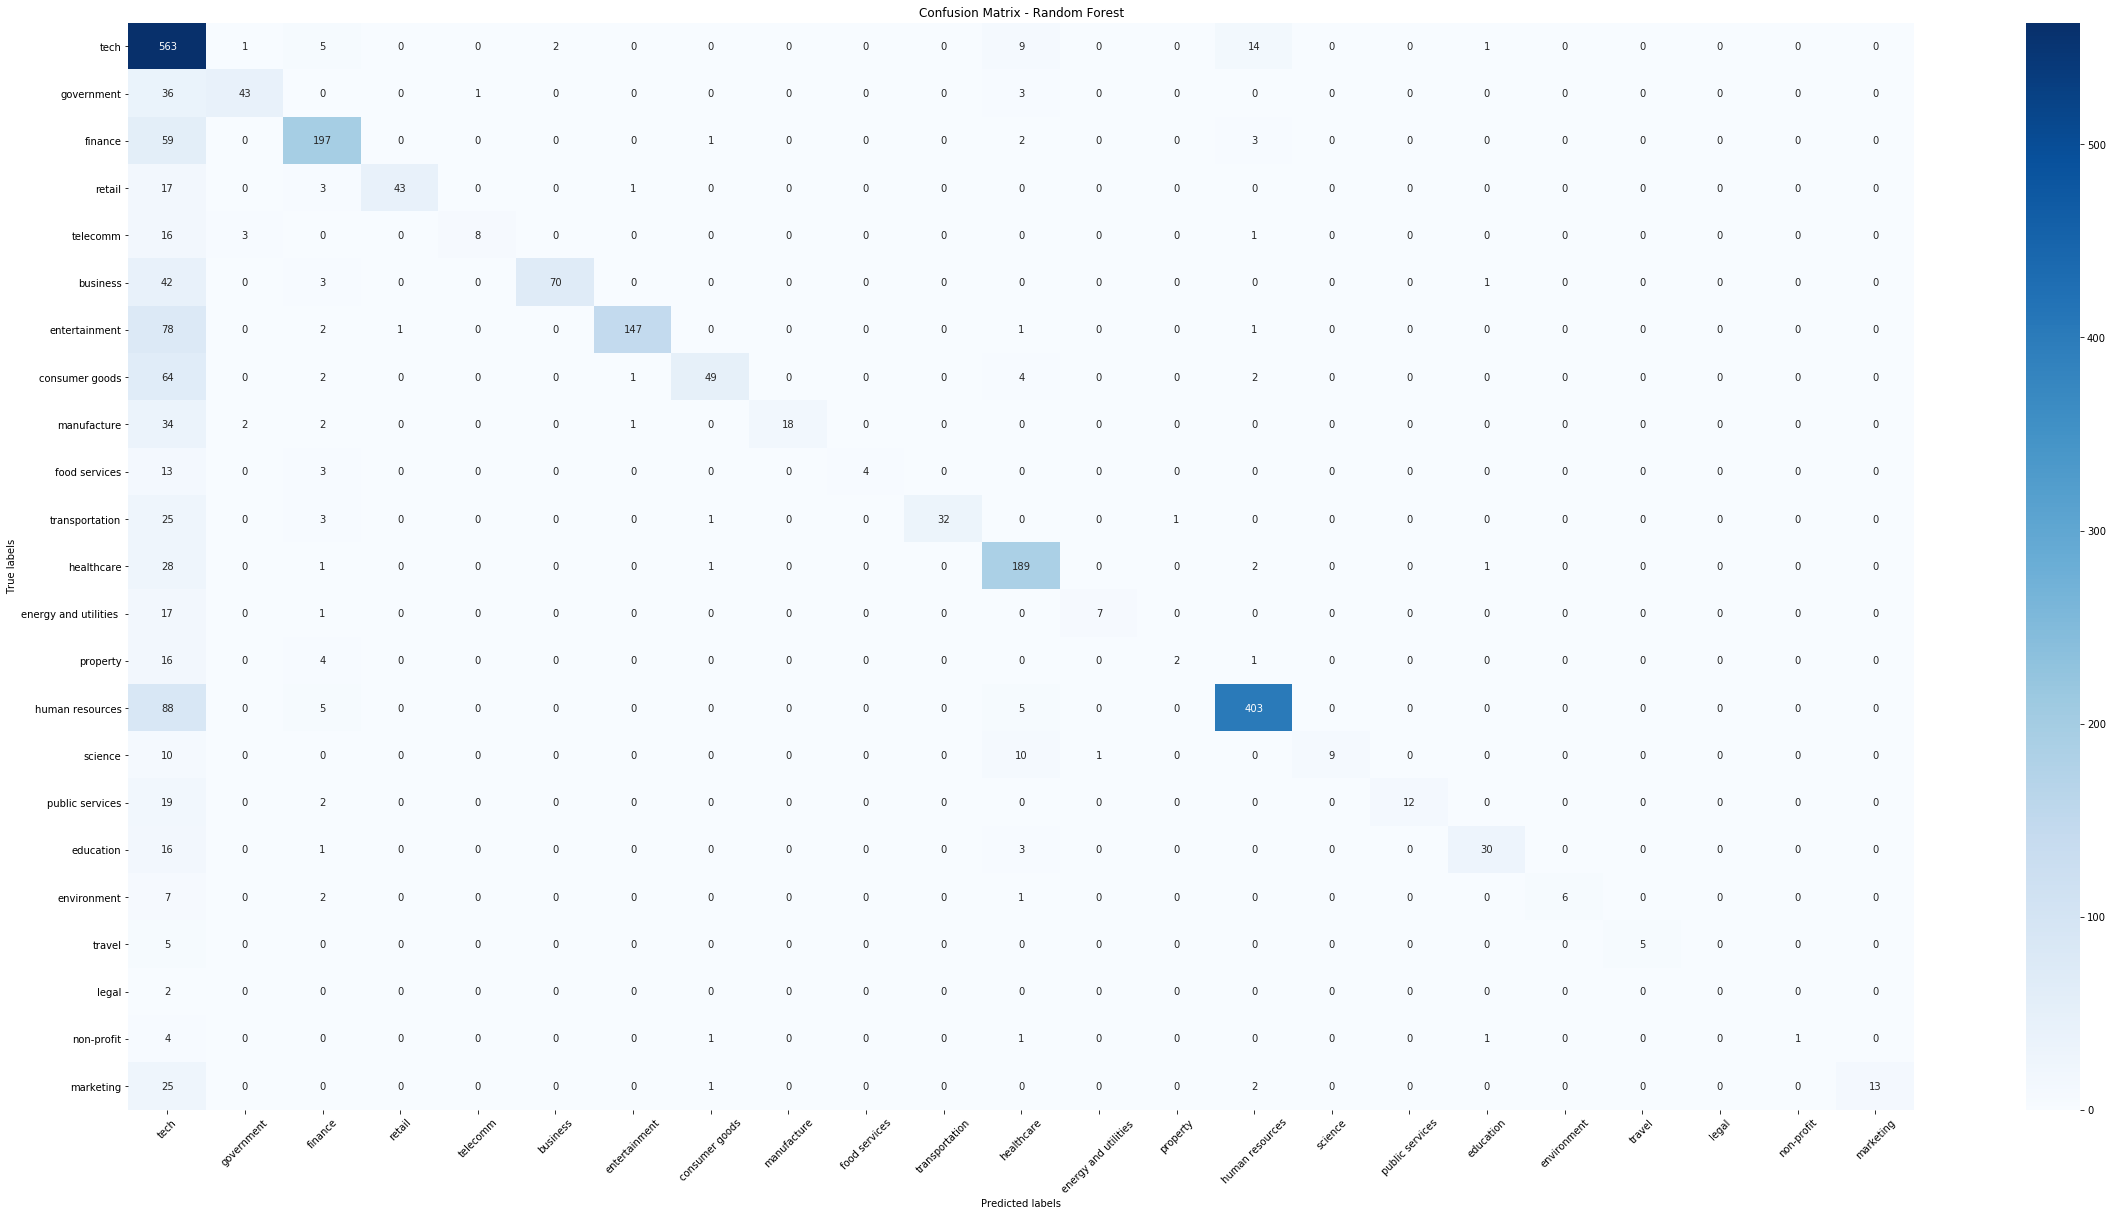

In [28]:
# this is use to help label the confusion matrix axis 
df_labels = labeled_df[['job_domain', 'domain_label']].drop_duplicates()

# now evaluate the model using confusion matrix 
cm = confusion_matrix(y_test_tfidf, y_pred, labels=df_labels.domain_label)

# let's plot the confusion matrix as heatmap and see how the model perform for each domain
fig, ax = plt.subplots(figsize=(40,20))

sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Random Forest'); 
ax.xaxis.set_ticklabels(df_labels.job_domain, rotation=45); 
ax.yaxis.set_ticklabels(df_labels.job_domain, rotation=0);

## 4.B. Train with Cleaned Job Descriptions

In [29]:
# transforming the data
tfidf_docs = tfidf_vectorizer.fit_transform(labeled_df["cleaned_jd"])  
print(tfidf_docs.shape)
tfidf_terms = tfidf_vectorizer.get_feature_names()

tf_docs = tf_vectorizer.fit_transform(labeled_df["cleaned_jd"])  
print(tf_docs.shape)
tf_terms = tf_vectorizer.get_feature_names()

# split into train and test set
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tf_docs, labeled_df.domain_label, 
                                                                stratify=y, random_state=RANDOM_SEED)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_docs, labeled_df.domain_label, 
                                                                            stratify=y, random_state=RANDOM_SEED)

(10399, 10000)
(10399, 10000)


### 4.B.1. Logistic Regression

In [30]:
# # set up the model and variables for training
# model = LogisticRegression()

# # define grid search
# grid_params = {
#                 'solver':['newton-cg', 'sag', 'lbfgs'],
#                 'C':[100, 10, 1.0, 0.1]
#                }
# cv = StratifiedKFold(random_state=RANDOM_SEED)
# grid_search = GridSearchCV(model, grid_params, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=10)
# grid_result = grid_search.fit(X_train_tf, y_train_tf)

# y_pred = grid_search.predict(X_test_tf)
# f1 = f1_score(y_test_tf, y_pred, average='weighted')

# # summarize results
# print("Best parameters: {}".format(grid_result.best_params_))
# print("Best cross-validation score: {:.4f}".format(grid_result.best_score_))
# print("F1 score with best parameters on the test set: {:.4f}".format(f1))

#-------------------------------------------------------------------------------
# The result is recorded below so we don't need to rerun this cell everytime
# Best parameters: {'C': 0.1, 'solver': 'newton-cg'}
# Best cross-validation score: 0.7024
# F1 score with best parameters on the test set: 0.7155

In [31]:
# using the best parameter found using grid search above and retrain a Logistic Regression model (reason for the retrain is because it takes a long time to run the gridsearch so don't want to rerun it everytime) 
model = LogisticRegression(C=0.1, solver='newton-cg', random_state=RANDOM_SEED)
model.fit(X_train_tf, y_train_tf)
y_pred = model.predict(X_test_tf)
f1 = f1_score(y_test_tf, y_pred, average='weighted')

print("F1 score with best parameters on the test set: {:.4f}".format(f1))

F1 score with best parameters on the test set: 0.7079


### 4.B.2. Random Forest Classifier

In [32]:
# # set up the model and variables for training
# model = RandomForestClassifier(random_state=RANDOM_SEED)

# # define grid search
# grid_params = {
#                 'min_samples_leaf':[1,5,15],
#                 'n_estimators': [500,700,950,1000],
#                 'max_depth': [150,200,250,300]
#                 }
# cv = StratifiedKFold(random_state=RANDOM_SEED)
# grid_search = GridSearchCV(model, grid_params, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=20)
# grid_result = grid_search.fit(X_train_tfidf, y_train_tfidf)

# y_pred = grid_search.predict(X_test_tfidf)
# f1 = f1_score(y_test_tfidf, y_pred, average='weighted')

# # summarize results
# print("Best parameters: {}".format(grid_result.best_params_))
# print("Best cross-validation score: {:.4f}".format(grid_result.best_score_))
# print("F1 score with best parameters on the test set: {:.4f}".format(f1))

#-------------------------------------------------------------------------------
# The result is recorded below so we don't need to rerun this cell everytime
# Best parameters: {'max_depth': 150, 'min_samples_leaf': 1, 'n_estimators': 700}
# Best cross-validation score: 0.6764
# F1 score with best parameters on the test set: 0.7019

In [33]:
# using the best parameter found using grid search above and retrain a RF model (reason for the retrain is because it takes a long time to run the gridsearch so don't want to rerun it everytime) 
model = RandomForestClassifier(max_depth=150, min_samples_leaf=1, n_estimators=700, random_state=RANDOM_SEED)
model.fit(X_train_tfidf, y_train_tfidf)
y_pred = model.predict(X_test_tfidf)
f1 = f1_score(y_test_tfidf, y_pred, average='weighted')

print("F1 score with best parameters on the test set: {:.4f}".format(f1))

F1 score with best parameters on the test set: 0.6999
